In [31]:
import tweepy
from tweepy import OAuthHandler
import json
from tweepy import Stream
from tweepy.streaming import StreamListener
import time

The requiered packages to connect into the Twitter API are downloaded

In [2]:
consumer_key = 'xxxxxxxxxxxxxxxxxxxxxxxxxx'
consumer_secret = 'xxxxxxxxxxxxxxxxxxxxxxxxxxxx'
access_token = 'xxxxxxxxxxxxxxxxxxxxxxxxxxxx'
access_secret = 'xxxxxxxxxxxxxxxxxxxxxxxxxxxx'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth)

The first step consists on registering the application into Twitter in order to extract the desired information. For registering: http://apps.twitter.com and you will receive the consumer key and a consumer secret. The other two variables are in the Keys and Acces Tokens part. 

In [5]:
def process_or_store(tweet):
    print(json.dumps(tweet))

The function process_or_store() is a place-holder for your custom implementation. In the simplest form, you could just print out the JSON, one tweet per line:

In [6]:
class MyListener(StreamListener):
    def __init__(self, time_limit=60):
        self.start_time = time.time()
        self.limit = time_limit
        self.saveFile = open('clasico_victoria.json', 'a')
        super(MyListener, self).__init__()

    def on_data(self, data):
        try:
            if (time.time() - self.start_time) < self.limit:
                self.saveFile.write(data)
                self.saveFile.write('\n')
                return True
            else:
                self.saveFile.close()
                return False
        except BaseException as e:
            print("Error on_data: ",str(e),"")
            return True

    def on_error(self, status):
        print(status)
        return True

To keep the connection open for a period of time in order to gather information the streaming API is used. We create a messi_victoria.json file to save all the tweets. The defaul limit time of open connection is 60 seconds. 

In [ ]:
twitter_stream = Stream(auth, MyListener(time_limit=360))
twitter_stream.filter(track=['#Clasico'])

To obtain all the "#Clasico" tweets for 6 minutes

Once the json file has been saved with all the features for each tweet. The key atributes for each tweet are:

text: the text of the tweet itself

created_at: the date of creation

favorite_count, retweet_count: the number of favourites and retweets

favorited, retweeted: boolean stating whether the authenticated user (you) have favourited or retweeted this tweet

lang: acronym for the language (e.g. “en” for english)

id: the tweet identifier

place, coordinates, geo: geo-location information if available

user: the author’s full profile




In [30]:
%matplotlib inline
from nltk.tokenize import word_tokenize
import re
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from nltk.corpus import stopwords
import string
from regex import VERSION1, UNICODE, compile

Import the packages that will be requiered for further analysis

In [10]:
emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
    )"""

regex_str = [
    emoticons_str,
    r'<[^>]+>',  # HTML tags
    r'(?:@[\w_]+)',  # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)",  # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+',  # URLs

    r'(?:(?:\d+,?)+(?:\.?\d+)?)',  # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])",  # words with - and '
    r'(?:[\w_]+)',  # other words
    r'(?:\S)'  # anything else
]
tokens_re = re.compile(r'(' + '|'.join(regex_str) + ')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^' + emoticons_str + '$', re.VERBOSE | re.IGNORECASE)

If we try to directly tokenize the tweets text, the result wont be the desirable one as there are certain characters such as emoticons, URLS or Hashtacks that are not considered in the standard tokenize so it needs to be added.

In [7]:
def tokenize(s):
    return tokens_re.findall(s)

def preprocess(s, lowercase=False):
    tokens = tokenize(s)
    if lowercase:
        tokens = [token if emoticon_re.search(token) else token.lower() for token in tokens]
    return tokens

The tokenisation is based on regular expressions (regexp), which is a common choice for this type of problem

In [28]:
with open('clasico_victoria.json', 'r') as f:
    count_all = Counter()
    count_words_english = Counter()
    count_words_spanish = Counter()
    default = 'und'
    for line in f:
        if len(line)>1:
            tweet = json.loads(line)
            # Create a list with all the terms
            lenguage = preprocess(tweet.setdefault('lang',default))
            if len(lenguage)>0:
                lang_all = [lang for lang in lenguage]
                # Update the counter
                count_all.update(lang_all)

This part of the code wants to save all the languages used for the tweets referring to "#Clasico" in order to plot the most important ones. A Counter() object is created in order to save the list of languages. In order to avoid errors when the lenguage is missing, we create 'und' (undefined) as a default parameter

([<matplotlib.axis.XTick at 0x113680650>,
 <a list of 9 Text xticklabel objects>)

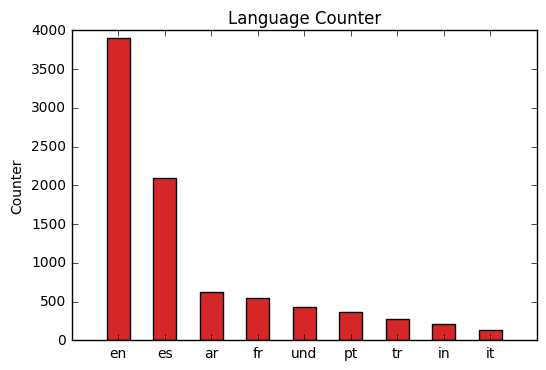

In [18]:
importants = count_all.most_common(9)
labels,ys = zip(*importants)
indexes = np.arange(len(labels))
p= plt.bar(indexes,ys,0.5,color='#d62728',align='center')
plt.ylabel('Counter')
plt.title('Language Counter')
plt.xticks(np.arange(len(ys)),labels)


I plot the 9 principal languages used to talk about the Clasico. As it was expected the main two languages are English, and Spanish.

As the amount of Undetermined language tweets is too high, I will use the langdetect package in order to determine the language from the tweet text

In [3]:
from langdetect import detect

In [19]:
with open('clasico_victoria.json', 'r') as f:
    count_all = Counter()
    count_words_english = Counter()
    count_words_spanish = Counter()
    default = 'und'    
    for line in f:
        if len(line)>1:
            tweet = json.loads(line)
            lenguage = preprocess(tweet.setdefault('lang',default))
            if lenguage==[u'und']:
                p=1
            if len(tweet)>3: 
                if lenguage=='und':
                    lenguage = detect(tweet['text'])
                    tweet['lang'] = lenguage
                lang_all = [lang for lang in lenguage]
                count_all.update(lang_all)
                if lenguage == [u'en']:
                    terms_all = [term for term in preprocess(tweet['text'])]
                    count_words_english.update(terms_all)
                elif lenguage == [u'es']:
                    terms_all = [term for term in preprocess(tweet['text'])]
                    count_words_spanish.update(terms_all)
    engl='The most used words in English are: '+str(count_words_english.most_common(10))+''
    sp='The most used words in Spanish are: '+str(count_words_spanish.most_common(10))+''
    print engl
    print sp

    

The most used words in English are: [(u'#ElClasico', 3311), (u':', 3130), (u'.', 3067), (u'RT', 2839), (u'!', 2330), (u'the', 1451), (u'\ud83d', 1425), (u'a', 1421), (u'#Messi', 1369), (u'\u2026', 1092)]
The most used words in Spanish are: [(u'.', 2256), (u':', 1770), (u'#ElClasico', 1720), (u'RT', 1482), (u'el', 965), (u'de', 830), (u'en', 813), (u'!', 782), (u'a', 753), (u'\u2026', 632)]


Next step will be to determine text frequency. I will focus in determining the most common words for English and for Spanish. As it can be seen from the output, the majority of the words are stopwords which do not provide valuable information, so will be omited using stopwords package:

In [12]:
punctuation = list(string.punctuation)
stop_english = stopwords.words('english') + punctuation + ['rt', 'via', '\*']
stop_spanish = stopwords.words('spanish') + punctuation + ['rt', 'via', '\*']

In [33]:
with open('clasico_victoria.json', 'r') as f:
    count_all = Counter()
    count_words_english = Counter()
    count_words_spanish = Counter()
    default = 'und'
    for line in f:
        if len(line) > 1:
            tweet = json.loads(line)
            lenguage = preprocess(tweet.setdefault('lang', default))
            if lenguage == [u'und']:
                p = 1
            if len(tweet) > 3:
                if lenguage == 'und':
                    lenguage = detect(tweet['text'])
                    tweet['lang'] = lenguage
                lang_all = [lang for lang in lenguage]
                count_all.update(lang_all)
                if lenguage == [u'en']:
                    terms_all = [term for term in preprocess(tweet['text']) if term not in stop_english]
                    count_words_english.update(terms_all)
                elif lenguage == [u'es']:
                    terms_all = [term for term in preprocess(tweet['text']) if term not in stop_spanish]
                    count_words_spanish.update(terms_all)
    engl='The most used words in English are: '+str(count_words_english.most_common(10))+''
    sp='The most used words in Spanish are: '+str(count_words_spanish.most_common(10))+''
    print engl
    print sp

The most used words in English are: [(u'#ElClasico', 3311), (u'RT', 2839), (u'\ud83d', 1425), (u'#Messi', 1369), (u'\u2026', 1092), (u'Messi', 975), (u'Barcelona', 964), (u'\u2705', 948), (u'Most', 944), (u'500', 903)]
The most used words in Spanish are: [(u'#ElClasico', 1720), (u'RT', 1482), (u'\u2026', 632), (u'#Messi', 546), (u'\xf3', 529), (u'\u2713', 528), (u'\ud83d', 488), (u'\xe1', 465), (u'Messi', 451), (u'goles', 365)]


A lot of them are emoticons and special characters which do not provide much information, su I import regex package:

In [44]:
with open('clasico_victoria.json', 'r') as f:
    count_all = Counter()
    count_words_english = Counter()
    count_words_spanish = Counter()
    default = 'und'
    for line in f:
        if len(line) > 1:
            tweet = json.loads(line)
            lenguage = preprocess(tweet.setdefault('lang', default))
            if lenguage == [u'und']:
                p = 1
            if len(tweet) > 3:
                if lenguage == 'und':
                    lenguage = detect(tweet['text'])
                    tweet['lang'] = lenguage
                lang_all = [lang for lang in lenguage]
                count_all.update(lang_all)
                if lenguage == [u'en']:
                    terms_all_new = [term for term in preprocess(tweet['text']) if term not in stop_english]
                    for j in range(len(terms_all_new)):
                        terms_all_new[j]= compile(ur'\p{^Latin}+', VERSION1 | UNICODE).sub('',terms_all_new[j])
                        count_words_english.update(terms_all_new)
                elif lenguage == [u'es']:
                    terms_all_new = [term for term in preprocess(tweet['text']) if term not in stop_spanish]
                    for j in range(len(terms_all_new)):
                        terms_all_new[j] = compile(ur'\p{^Latin}+', VERSION1 | UNICODE).sub('', terms_all_new[j])
                        count_words_spanish.update(terms_all_new)
    engl='The most used words in English are: '+str(count_words_english.most_common(10))+''
    sp='The most used words in Spanish are: '+str(count_words_spanish.most_common(10))+''
    print engl
    print sp

The most used words in English are: [(u'', 114296), (u'RT', 42675), (u'Messi', 27966), (u'Most', 26893), (u'#ElClasico', 26587), (u'\u2026', 21970), (u'goals', 19791), (u'\ud83d', 19623), (u'ElClasico', 18404), (u'Barcelona', 16866)]
The most used words in Spanish are: [(u'', 44953), (u'RT', 23914), (u'#ElClasico', 14508), (u'Messi', 12929), (u'\u2026', 12129), (u'\xe1', 10648), (u'ElClasico', 10055), (u'\xf3', 8871), (u'goles', 8082), (u's', 7129)]


This code will just omit the non LATIN words so emoticons will be erased as well as #. It is important to mention that some important words will be omitted to as 500 (the number of goals that Messi has scored)

Sometimes we are interested in the terms that occur together. This is mainly because the context gives us a better insight about the meaning of a term, I will implement the code to determine the words that occur together.

In [36]:
from collections import defaultdict
# Returns a new dictionary-like object. It overrides one method and adds one writable instance variable
import operator
# to acces the key in sorted. It provides methods such as itemsgetter

In [48]:
com = defaultdict(lambda : defaultdict(int)) #in order to expect int's
with open('clasico_victoria.json', 'r') as f:
    count_all = Counter()
    count_words_english = Counter()
    count_words_spanish = Counter()
    default = 'und'
    com = defaultdict(lambda : defaultdict(int)) #in order to expect int's
    counter_tweets = 0 #in order to count all the tweets that have 'text' and 'lang'
    for line in f:
        if len(line)>1:
            tweet = json.loads(line)
            if ("text" in tweet) & ("lang" in tweet):
                if (tweet['lang'] == u'en'):
                    counter_tweets += 1
                    terms_only = [term for term in preprocess(tweet['text'])
                                  if term not in stop_english
                                  and not term.startswith(('#', '@'))]
                    count_all.update(terms_only)
                    # Build co-occurrence matrix
                    for i in range(len(terms_only)-1):
                        for j in range(i+1, len(terms_only)):
                            w1, w2 = sorted([terms_only[i], terms_only[j]])
                            if w1 != w2:
                                com[w1][w2] += 1

In order to know what two words tend to be together

In [40]:
com_max = []
for t1 in com:
    t1_max_terms = sorted(com[t1].items(), key=operator.itemgetter(1), reverse=True)[:5] #sorting by number of occurances
    for t2, t2_count in t1_max_terms:
        com_max.append(((t1, t2), t2_count))
terms_max = sorted(com_max, key=operator.itemgetter(1), reverse=True)
print(terms_max[:10]) #print the 10 higher co-ocurrances


[((u'Most', u'\u2705'), 3760), ((u'\ud83d', u'\ude0d'), 3326), ((u'\ud83d', u'\ude2d'), 2504), ((u'Most', u'goals'), 2333), ((u'goals', u'\u2705'), 2328), ((u'\u2705', u'\ud83c'), 1824), ((u'Most', u'\ud83c'), 1824), ((u'\xa0', u'\u2705'), 1668), ((u'Most', u'\xa0'), 1668), ((u'\ud83d', u'\udd25'), 1301)]


As for this case I did not omit the emoticons and special character, the results are not as much clear as expected. I will filter by a word, for example Messi:

In [42]:
with open('clasico_victoria.json', 'r') as f:
    count_all = Counter()
    count_words_english = Counter()
    count_words_spanish = Counter()
    default = 'und'
    com = defaultdict(lambda: defaultdict(int))  # in order to expect int's
    counter = 1
    search_word = 'Messi' # paste whatever you want
    count_search = Counter()
    for line in f:
        if len(line) > 1:
            tweet = json.loads(line)
            if ("text" in tweet) & ("lang" in tweet):
                if (tweet['lang'] == u'en'):
                    terms_only = [term for term in preprocess(tweet['text']) 
                    if term not in stop_english 
                    and not term.startswith(('#', '@'))]
                    if search_word in terms_only:
                        count_search.update(terms_only)
    print("Co-occurrence for %s:" % search_word)
    print(count_search.most_common(20))


Co-occurrence for Messi:
[(u'Messi', 975), (u'RT', 717), (u'Lionel', 415), (u'\u2026', 408), (u'Barcelona', 402), (u'500', 366), (u'goal', 355), (u'th', 306), (u'\ud83d', 279), (u'2', 253), (u'3', 238), (u'The', 231), (u'time', 220), (u'scores', 218), (u'wins', 209), (u'away', 195), (u'victory', 190), (u'added', 190), (u'seal', 190), (u'No10', 190)]


Now I am going to do Sentimental Analysis. The method used is using Semantic Orientation. SO of a word is the difference between its associations with positive and negative words. In practice, we want to calculate “how close” a word is with terms like good and bad. The chosen measure of “closeness” is Pointwise Mutual Information (PMI)

In [53]:
from __future__ import division # in order to do floating divisions. if not a lot of 0.xxx would result in 0
import math

In [50]:
p_t = {}
p_t_com = defaultdict(lambda: defaultdict(int))
for term, n in count_all.items():
    p_t[term] = n / counter_tweets 
    for t2 in com[term]:
        p_t_com[term][t2] = com[term][t2] / counter_tweets

In [51]:
positive_vocab = [
    'good', 'nice', 'great', 'awesome', 'outstanding',
    'fantastic', 'terrific', ':)', ':-)', 'like', 'love','best','victory'
]
negative_vocab = [
    'bad', 'terrible', 'crap', 'useless', 'hate', ':(', ':-(','defeat','loss'
    # 'defeat', etc.
]

In [54]:
pmi = defaultdict(lambda : defaultdict(int))
for t1 in p_t:
    for t2 in com[t1]:
        denom = p_t[t1] * p_t[t2]
        pmi[t1][t2] = math.log(p_t_com[t1][t2] / denom,2) #the formula of PMI 
 
semantic_orientation = {} # a dictionary that will be changing size
for term, n in p_t.items():
    positive_assoc = sum(pmi[term][tx] for tx in positive_vocab)
    negative_assoc = sum(pmi[term][tx] for tx in negative_vocab)
    semantic_orientation[term] = positive_assoc - negative_assoc


In [55]:
semantic_sorted = sorted(semantic_orientation.items(), 
                         key=operator.itemgetter(1), 
                         reverse=True)
top_pos = semantic_sorted[:10]
top_neg = semantic_sorted[-10:]
 
print(top_pos)
print(top_neg)

[(u'Its', 15.765931822480063), (u'equally', 15.163549793016456), (u'feel', 14.733966460833498), (u'Aref', 13.840228462829227), (u'alwaysss', 13.801754315014591), (u'Wht', 13.801754315014591), (u'aya', 13.801754315014591), (u'anarl', 13.526119872401164), (u'certain', 13.526119872401164), (u'Gallowgate', 13.526119872401164)]
[(u'Wembley', -10.928518375257891), (u'https://t.co/erezPl6CEf', -10.928518375257891), (u'Madrid', -11.167021091772336), (u'Barcelona', -11.327960109150103), (u'kid', -11.928518375257891), (u'plz', -11.928518375257891), (u'Black', -11.928518375257891), (u'meme', -11.928518375257891), (u'share', -11.928518375257891), (u'tag', -11.928518375257891)]


Results still to be analyzed.